## Import

In [1]:
import os, sys, inspect, time

import numpy as np
import torch 
import matplotlib.pyplot as plt
torch.multiprocessing.set_sharing_strategy('file_system')

import discrepancy, visualization
from algorithms import ABC_algorithms, SMCABC, SMC2ABC, SNLABC, SNL2ABC
from problems import problem_GC

import utils_os, utils_math

%load_ext autoreload
%autoreload 2

## Problem Definition

visualizing p(x|theta)


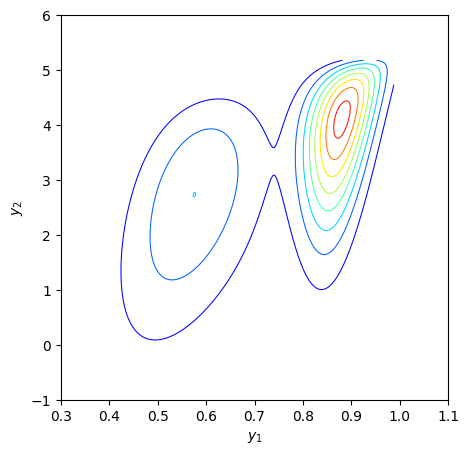

<Figure size 500x400 with 0 Axes>

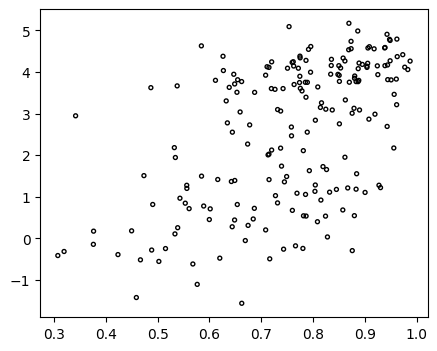

In [2]:
DIR = 'results/GC'                                             
RERUN = not utils_os.is_file_exist(DIR, 'true_samples.npy') 

## Define the problem
problem = problem_GC.Gaussian_Copula_Problem(N=500, n=200)
true_theta = problem.get_true_theta()

## Get x_o ~ p(x|theta)
if RERUN:
    # observed stat
    problem.data_obs = problem.simulator(true_theta)
    problem.y_obs = problem.statistics(data=problem.data_obs, theta=true_theta)
    utils_os.save_object(DIR, 'data_obs', problem.data_obs)
    utils_os.save_object(DIR, 'y_obs', problem.y_obs)
    
    # collect samples
    true_samples = problem.sample_from_true_posterior()
    utils_os.save_object(DIR, 'true_samples', true_samples)
else:
    true_samples = utils_os.load_object(DIR, 'true_samples.npy')
    problem.data_obs  = utils_os.load_object(DIR, 'data_obs.npy')
    problem.y_obs  = utils_os.load_object(DIR, 'y_obs.npy')
    
## Visualize the problem
problem.visualize()
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(0,1))
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(1,2))
# visualization.plot_likelihood(samples=true_samples, log_likelihood_function=problem.log_likelihood, dimensions=(0,2))
plt.figure(figsize=(5,4))
visualization.plot_samples(problem.data_obs)

## Inference

### SMC

iteration  0
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  1
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  2
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  3
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  4
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  5
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  6
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  7
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  8
# of cpus =  4
> learning fake posterior 
> learning true posterior 


iteration  9
# of cpus =  4
> learning fake posterior 
fitting Gaussian copula progress= 0.0 loss= 2298.010498046875
fitting Gaussian copula progress= 0.1 loss= 835.0341796875
fitting Gaussian copula progress= 0.2 loss= 549.2060546875
fitting G

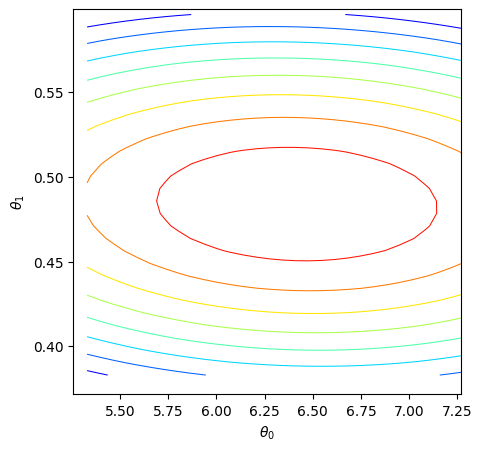

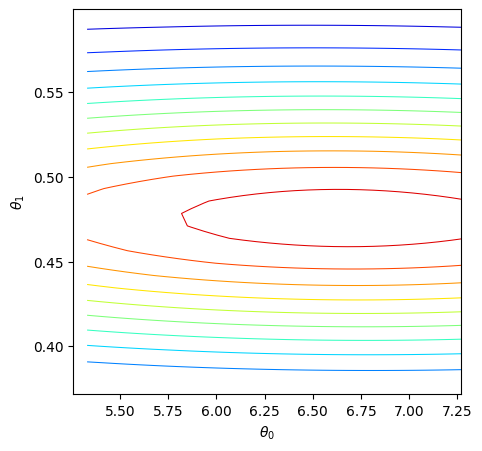

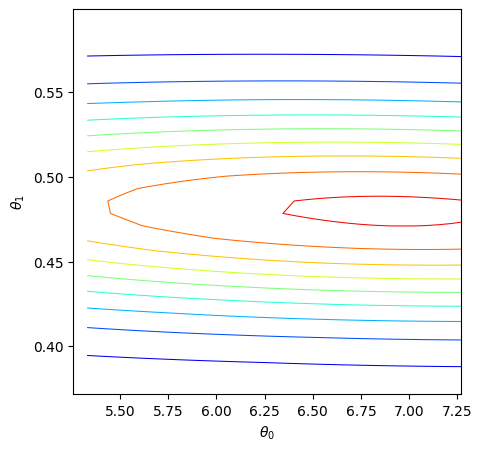

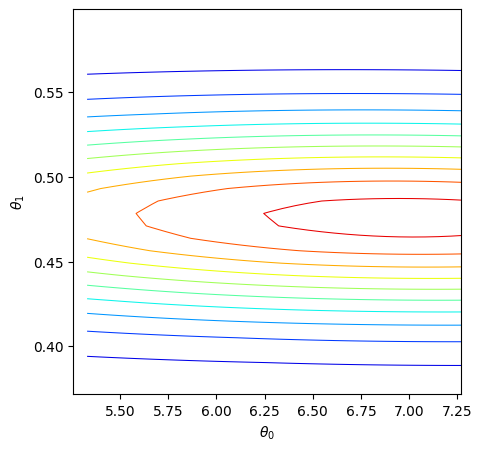

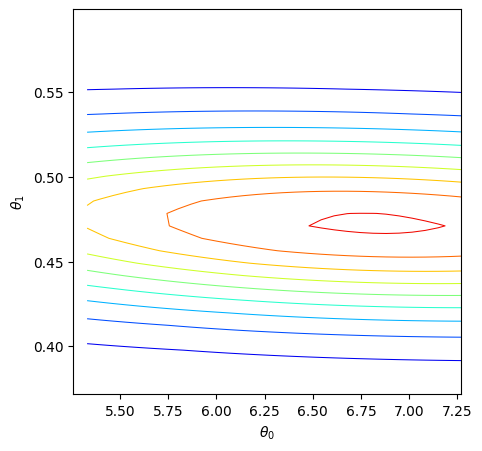

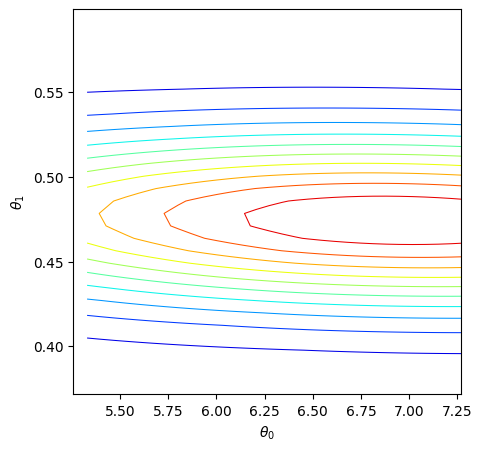

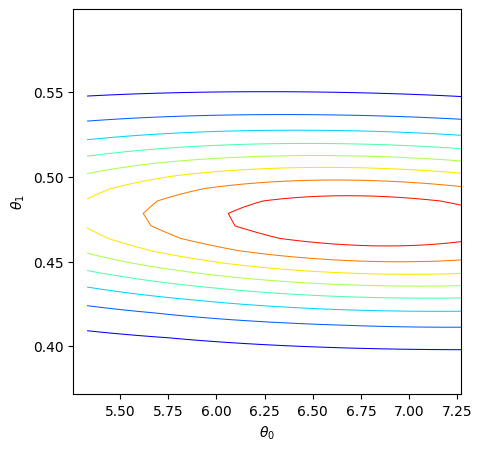

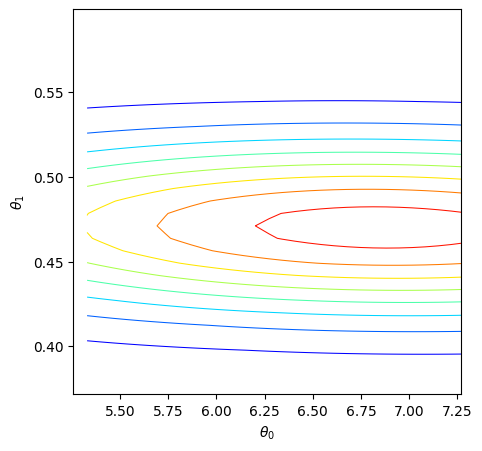

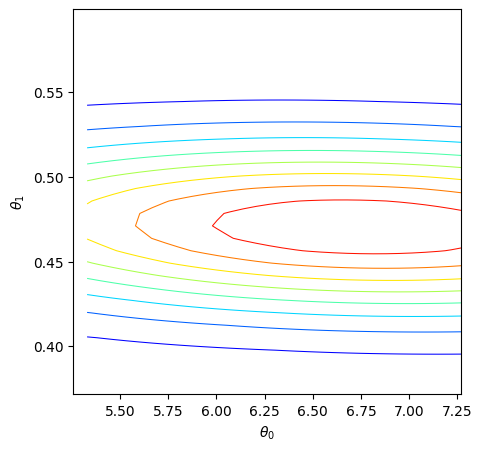

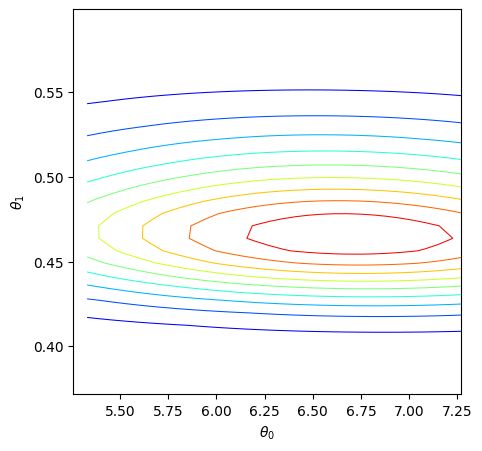

In [3]:
## Sequential Monte Carlo ABC

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda:1'
hyperparams.num_sim = 4000                        # number of simulations
hyperparams.num_samples = 200                     # number of samples to represent posterior
hyperparams.L = 10                                 # number of rounds in sequential learning

smc_abc = SMCABC.SMC_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc_abc.run()

JSD_smc_array = []
for l in range(hyperparams.L):
    print('round =', l)
    smc_abc.posterior = smc_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc_array.append(JSD)
    print('JSD smc = ', JSD)
utils_os.save_object(DIR, 'JSD_SMC', JSD_smc_array)

iteration  0
# of cpus =  4

 > fitting encoder
summary statistic dim = 6 original dim = 41
architecture [41, 100, 100, 6]
finished: t= 0 loss= 1.3952844142913818 loss val= 1.3949249982833862 best loss 1.3949249982833862
finished: t= 200 loss= 0.6350449919700623 loss val= 0.640931248664856 best loss 0.6262844800949097
finished: t= 400 loss= 0.4337463080883026 loss val= 0.5156549215316772 best loss 0.47289183735847473
finished: t= 600 loss= 0.29122602939605713 loss val= 0.33972012996673584 best loss 0.33226484060287476
finished: t= 800 loss= 0.18875719606876373 loss val= 0.2709636986255646 best loss 0.2191106081008911
finished: t= 1000 loss= 0.20028531551361084 loss val= 0.21997061371803284 best loss 0.19904184341430664
finished: t= 1200 loss= 0.15753042697906494 loss val= 0.2077014446258545 best loss 0.18073409795761108
finished: t= 1400 loss= 0.14107811450958252 loss val= 0.20420777797698975 best loss 0.18073409795761108
finished: t= 1600 loss= 0.12972639501094818 loss val= 0.22782880

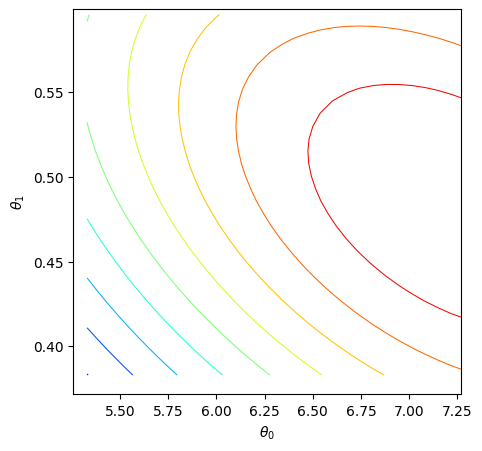

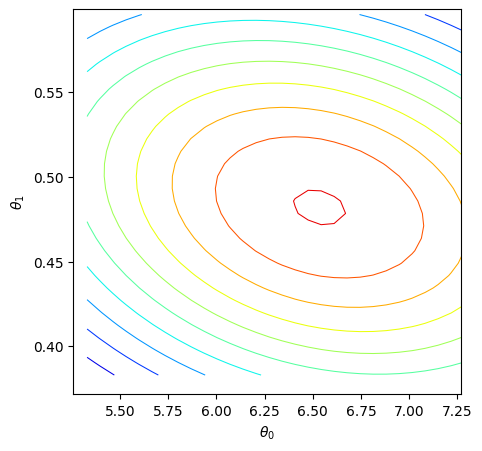

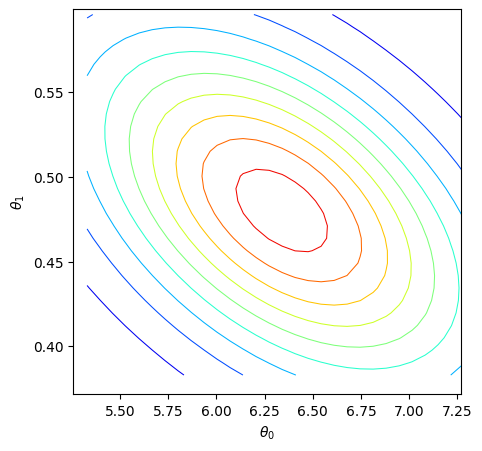

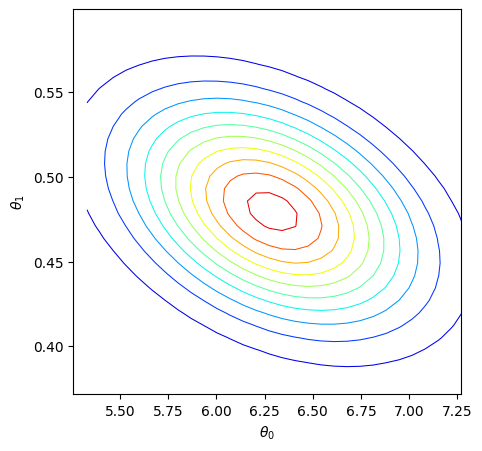

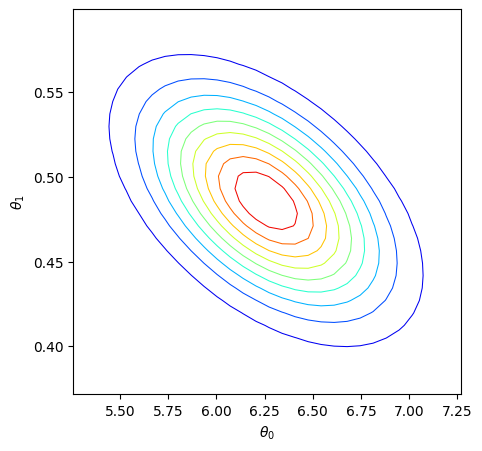

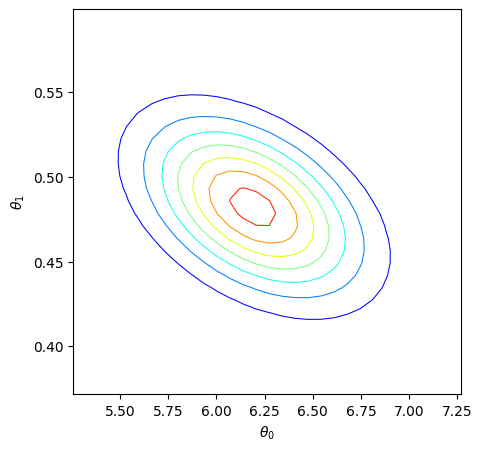

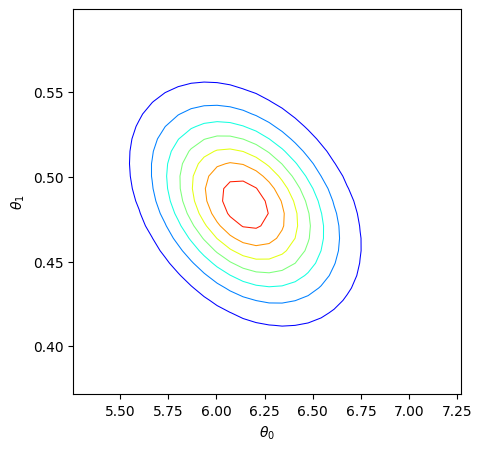

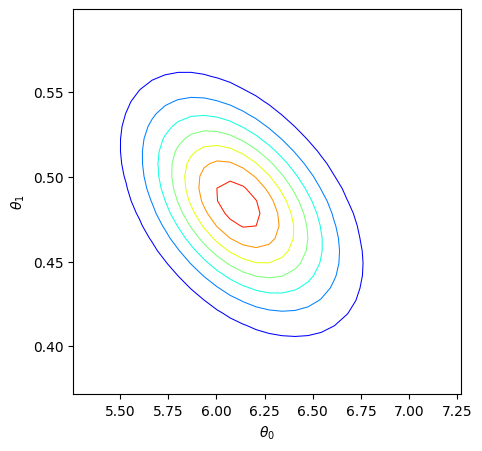

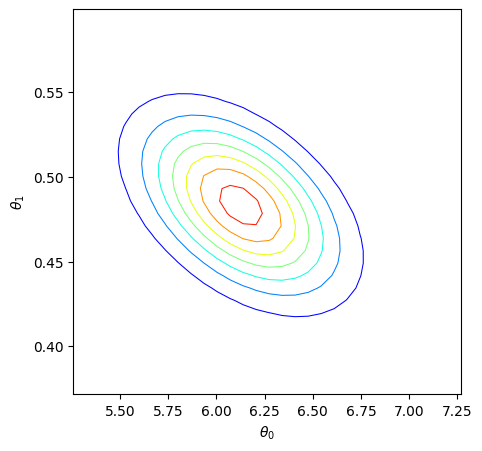

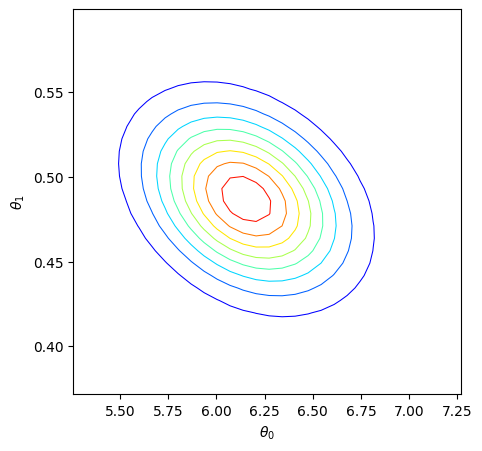

In [4]:
## Sequential Monte Carlo ABC +

hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda'
hyperparams.num_sim = 4000                       # number of simulations
hyperparams.num_samples = 200                    # number of samples to represent posterior
hyperparams.L = 10                                # number of learning rounds
hyperparams.type = 'plain'                       # the network architecture of S(x)
hyperparams.stat = 'infomax'                     # statistics function: infomax/moment/score  
hyperparams.estimator = 'JSD'                    # MI estimator; JSD (accurate) or DC (fast)

smc2_abc = SMC2ABC.SMC2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
smc2_abc.run()

JSD_smc2_array = []
for l in range(len(smc2_abc.posterior_array)):
    print('l=', l)
    smc2_abc.l = l
    smc2_abc.posterior = smc2_abc.posterior_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=smc2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, smc2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_smc2_array.append(JSD)
    print('JSD smc2 = ', JSD)
utils_os.save_object(DIR, 'JSD_SMC2', JSD_smc2_array)

### SNL


 SNL ABC
iteration  0
# of cpus =  4
finished: t= 0 loss= 186.1209259033203 loss val= 187.18856811523438 best loss 187.18856811523438
finished: t= 200 loss= -29.09149742126465 loss val= -27.38728141784668 best loss -27.38728141784668
finished: t= 400 loss= -50.19001007080078 loss val= -48.2232551574707 best loss -48.2232551574707
finished: t= 600 loss= -68.031982421875 loss val= -63.945919036865234 best loss -63.945919036865234
finished: t= 800 loss= -75.0381088256836 loss val= -68.36225891113281 best loss -68.58255767822266
finished: t= 1000 loss= -78.88313293457031 loss val= -70.14810180664062 best loss -71.06261444091797
finished: t= 1200 loss= -82.02899932861328 loss val= -71.318115234375 best loss -72.39864349365234
finished: t= 1400 loss= -83.2372055053711 loss val= -72.36932373046875 best loss -73.05786895751953
finished: t= 1600 loss= -85.3022689819336 loss val= -70.25528717041016 best loss -73.05786895751953
finished: t= 1800 loss= -87.27763366699219 loss val= -70.08583831787

finished: t= 0 loss= 145.6263885498047 loss val= 140.7519989013672 best loss 140.7519989013672
finished: t= 200 loss= -67.1984634399414 loss val= -73.27501678466797 best loss -73.74785614013672
finished: t= 400 loss= -75.76022338867188 loss val= -81.44361877441406 best loss -81.79084777832031
finished: t= 600 loss= -80.45097351074219 loss val= -83.11608123779297 best loss -84.73824310302734
finished: t= 800 loss= -83.003662109375 loss val= -84.23768615722656 best loss -86.15805053710938
finished: t= 1000 loss= -86.42195892333984 loss val= -86.53065490722656 best loss -86.80387115478516
finished: t= 1200 loss= -86.92974090576172 loss val= -86.0307846069336 best loss -87.27166748046875
finished: t= 1400 loss= -87.85852813720703 loss val= -86.8578872680664 best loss -87.7154541015625
finished: t= 1600 loss= -89.32528686523438 loss val= -87.35467529296875 best loss -87.9789047241211
finished: t= 1800 loss= -88.90337371826172 loss val= -87.25765991210938 best loss -88.2025375366211


iterat

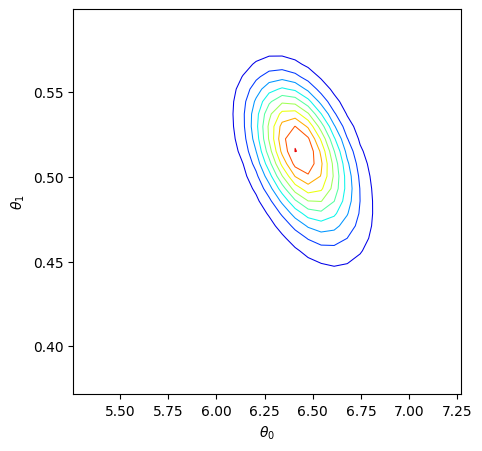

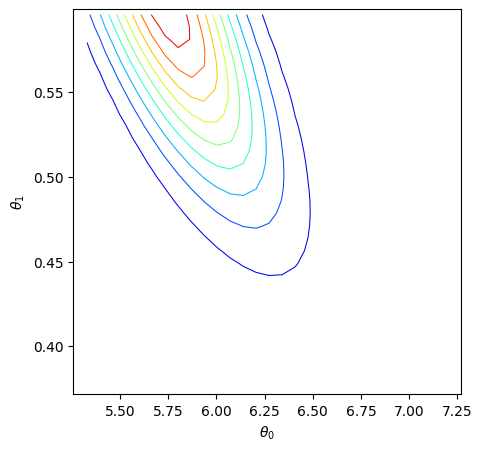

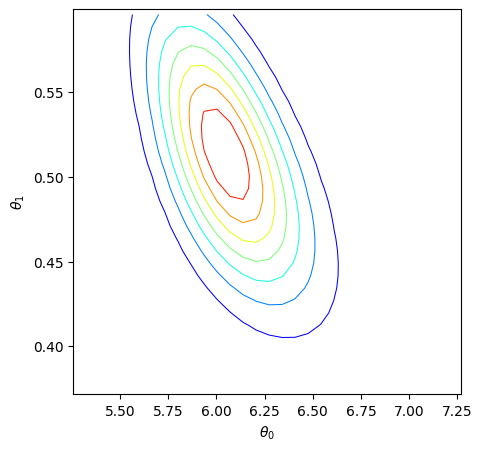

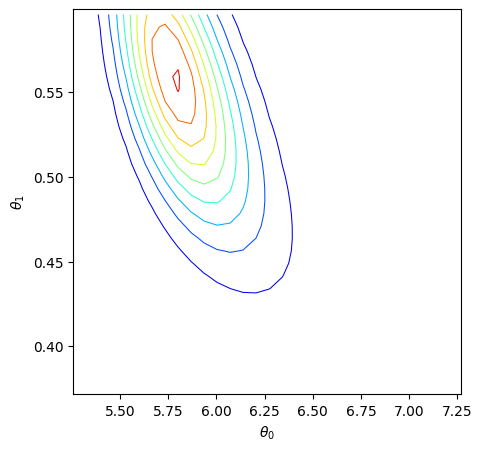

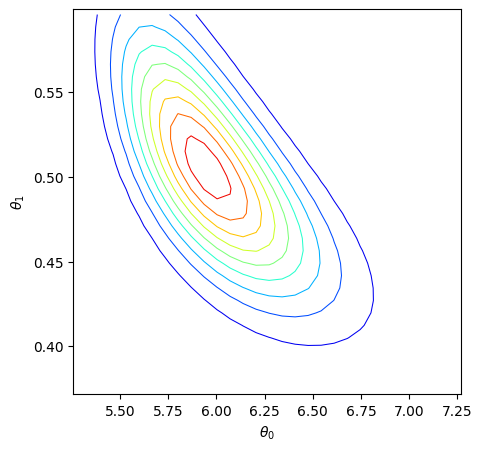

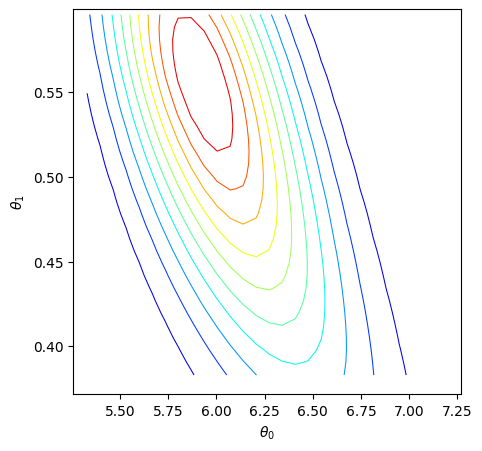

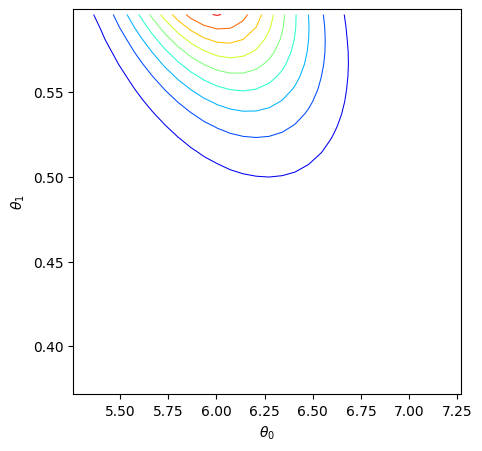

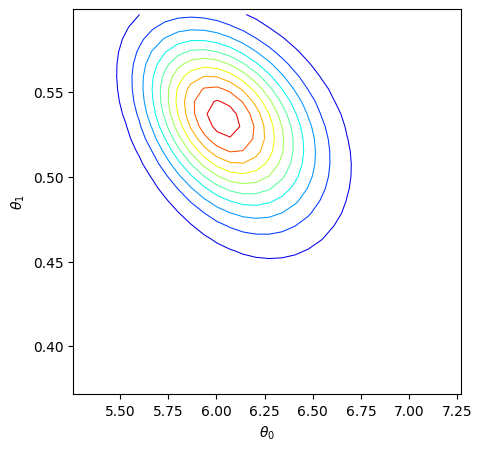

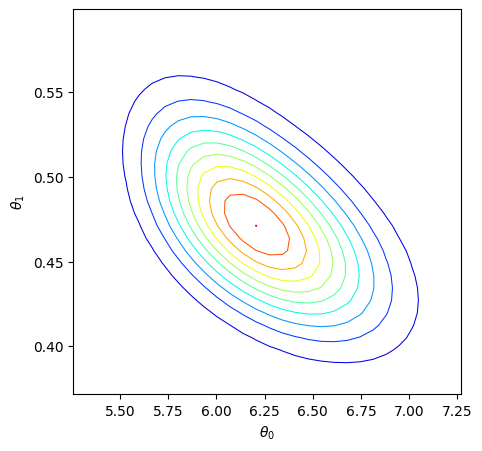

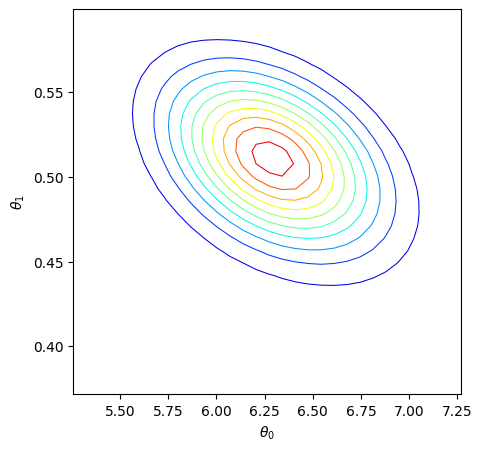

In [5]:
## Sequential Neural Likelihood
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda'
hyperparams.num_sim = 4000
hyperparams.L = 10

print('\n SNL ABC')
snl_abc = SNLABC.SNL_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl_abc.run()

JSD_array = []
for l in range(len(snl_abc.nde_array)):
    print('l=', l)
    snl_abc.nde_net = snl_abc.nde_array[l]
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl = ', JSD)
utils_os.save_object(DIR, 'JSD_SNL', JSD_array)

iteration  0
# of cpus =  4

 > fitting encoder
summary statistic dim = 6 original dim = 41
architecture [41, 100, 100, 6]
finished: t= 0 loss= -0.25929373502731323 loss val= -0.2779340445995331 best loss -0.2779340445995331
finished: t= 200 loss= -0.9974328875541687 loss val= -0.9972938299179077 best loss -0.9972972273826599
finished: t= 400 loss= -0.9982330799102783 loss val= -0.9976751804351807 best loss -0.9976787567138672
finished: t= 600 loss= -0.9984694123268127 loss val= -0.9978746175765991 best loss -0.9978865385055542
finished: t= 800 loss= -0.9984402656555176 loss val= -0.9977808594703674 best loss -0.9979268908500671
finished: t= 1000 loss= -0.9986951351165771 loss val= -0.9978734254837036 best loss -0.9979599118232727
finished: t= 1200 loss= -0.9983775019645691 loss val= -0.997456431388855 best loss -0.9979599118232727
finished: t= 1400 loss= -0.998838484287262 loss val= -0.9977304339408875 best loss -0.9979599118232727
finished: t= 1600 loss= -0.9985658526420593 loss val=

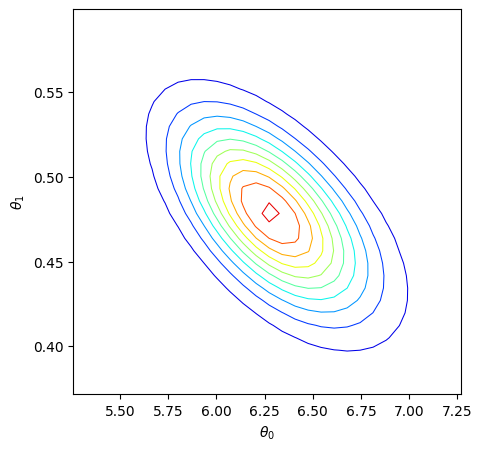

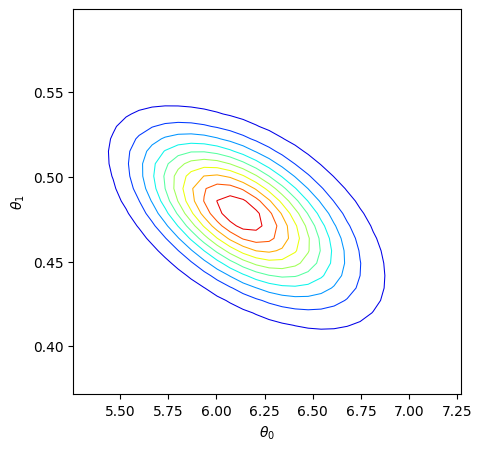

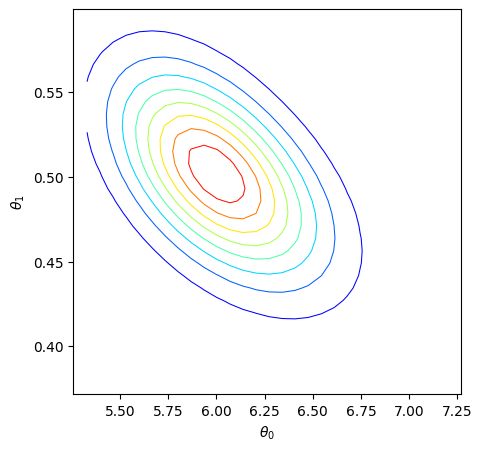

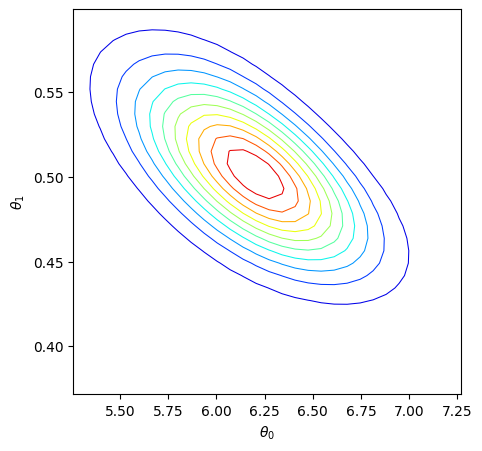

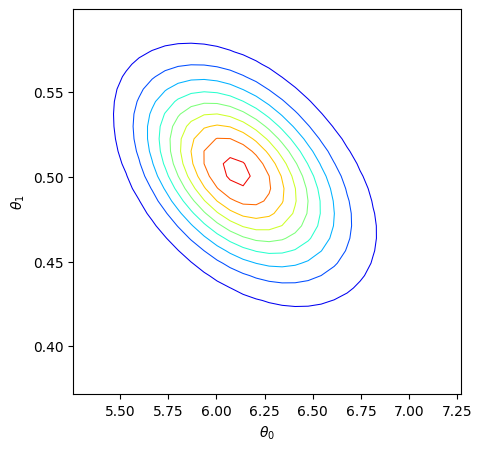

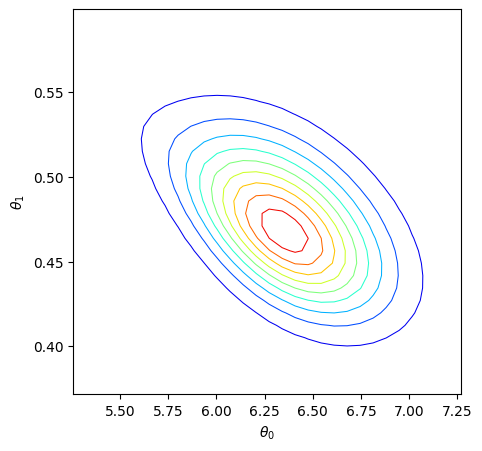

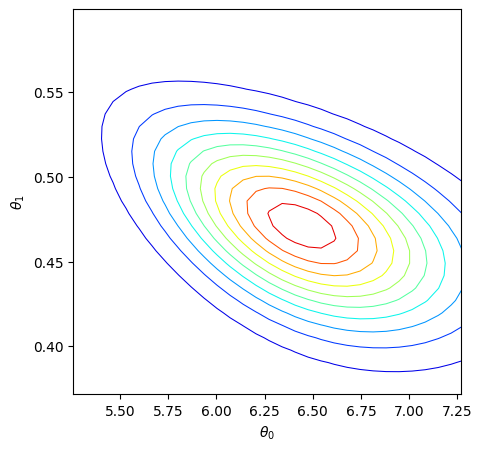

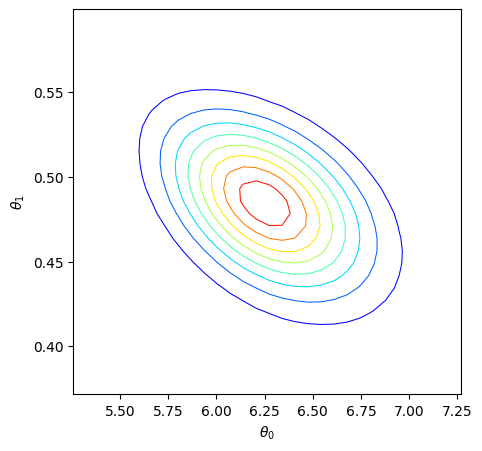

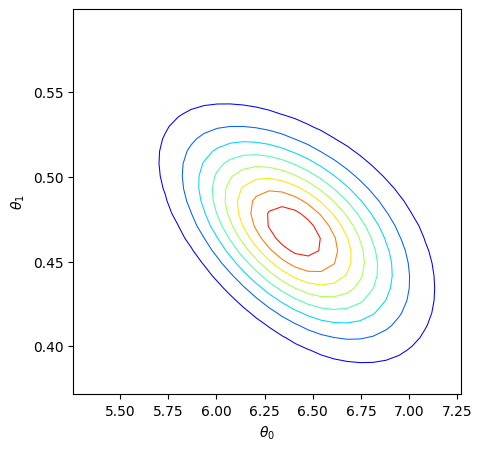

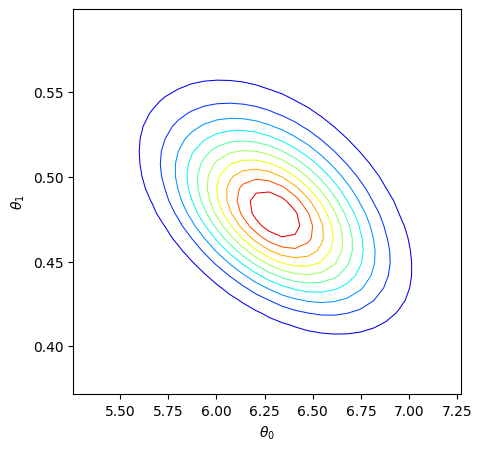

In [6]:
### Sequential Neural Likelihood + 
hyperparams = ABC_algorithms.Hyperparams()
hyperparams.save_dir = DIR
hyperparams.device = 'cuda'
hyperparams.num_sim = 4000                       # number of simulations
hyperparams.L = 10                                # number of learning rounds
hyperparams.type = 'plain'                       # the network architecture of S(x)
hyperparams.stat = 'infomax'                     # statistics function: infomax/moment/score  
hyperparams.estimator = 'DC'                     # MI estimator; JSD (accurate) or DC (fast)
hyperparams.nde = 'MAF'                          # nde; MAF (D>1) or MDN (D=1)

snl2_abc = SNL2ABC.SNL2_ABC(problem, discrepancy=discrepancy.eculidean_dist, hyperparams=hyperparams)
snl2_abc.run()

JSD_array = []
for l in range(len(snl2_abc.nde_array)):
    print('l=', l)
    snl2_abc.set(l=l)
    visualization.plot_likelihood(samples=true_samples, log_likelihood_function=snl2_abc.log_likelihood, dimensions=(0,1))
    JSD = discrepancy.JSD(problem.log_likelihood, snl2_abc.log_likelihood, true_samples, true_samples, N_grid=30)
    JSD_array.append(JSD)
    print('JSD snl+ = ', JSD)
utils_os.save_object(DIR, 'JSD_SNL2', JSD_array)